In [2]:

import numpy as np
import seaborn as sns
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from asymopt.geom import build_metal_sub_lig_comp_mol
from asymopt.desc import  maxminscale,process_desc
from asymopt.ml import model_delta_pred
from rdkit import Chem
import pandas as pd

In [3]:
model_ens_map = {'XGB':XGBRegressor(n_jobs=-1,random_state=0),'LGBM':LGBMRegressor(n_jobs=-1,verbosity=-1,random_state=0),
                 'RF':RandomForestRegressor(n_jobs=-1,random_state=0),'DT':DecisionTreeRegressor(random_state=0),
                 "ET":ExtraTreesRegressor(n_jobs=-1,random_state=0)}

In [4]:
com_df = pd.read_csv('../data/processed/com_data.csv')
lit_df = pd.read_csv('../data/processed/lit_data_with_cplex_smi.csv')

l_rct1_smi_lst,l_rct2_smi_lst,l_metal_lst,l_lig_smi_lst,l_tgt = lit_df['rct_1_smi'].to_list(),lit_df['rct_2_smi'].to_list(),lit_df['metal'].to_list(),lit_df['lig_smi'].to_list(),lit_df['ddG'].to_numpy()

c_rct1_smi_lst,c_rct2_smi_lst,c_metal_lst,c_lig_smi_lst,c_tgt = com_df['rct_1_smi'].to_list(),com_df['rct_2_smi'].to_list(),com_df['metal'].to_list(),com_df['lig_smi'].to_list(),com_df['ddG'].to_numpy()


In [5]:
vir_lig_group_map = np.load('../ligand_pool/vir_lig_smi_map.npy',allow_pickle=True).item()
vir_lig_comp_map = np.load('../ligand_pool/vir_lig_comp_map.npy',allow_pickle=True).item()
vir_lig2comp_map = {smi1:smi2 for smi1,smi2 in vir_lig_comp_map.values()}
vir_lig_sas_inf = np.load('../ligand_pool/smi_sascore_map.npy',allow_pickle=True).item()
vir_lig_smi_lst = list(vir_lig_group_map.values())
sel_vir_lig_smi_lst = [smi for smi,score in vir_lig_sas_inf.items() if score < 4]
sel_vir_com_smi_lst = [vir_lig2comp_map[smi] for smi in sel_vir_lig_smi_lst]

In [6]:
com_fp_arr = np.load("../descriptor/com_fp_arr.npy",allow_pickle=True)
com_rdkit_arr = np.load("../descriptor/com_rdkit_arr.npy",allow_pickle=True)
acsf_map = np.load("../descriptor/others/acsf.npy",allow_pickle=True).item()
mbtr_map = np.load("../descriptor/others/mbtr.npy",allow_pickle=True).item()
physorg_map = np.load("../descriptor/others/physorg.npy",allow_pickle=True).item()
com_complex_fp_lst = []
com_complex_rdkit_lst = []
com_rxn_physorg_lst = []
com_rxn_acsf_lst = []
com_rxn_mbtr_lst = []

for c_r1,c_r2,c_m,c_l in zip(c_rct1_smi_lst,c_rct2_smi_lst,c_metal_lst,c_lig_smi_lst):
    comp_smi = Chem.MolToSmiles(build_metal_sub_lig_comp_mol(c_r1,c_r2,c_m,c_l))
    com_rxn_acsf_lst.append(np.concatenate([acsf_map["rct1"][c_r1], acsf_map["rct2"][c_r2], acsf_map["lig"][(c_l,c_m)]]))
    com_rxn_mbtr_lst.append(np.concatenate([mbtr_map["rct1"][c_r1], mbtr_map["rct2"][c_r2], mbtr_map["lig"][(c_l,c_m)]]))
    com_rxn_physorg_lst.append(np.concatenate([physorg_map["rct1"][c_r1], physorg_map["rct2"][c_r2], physorg_map["lig"][(c_l,c_m)]]))
com_rxn_physorg_lst = np.array(com_rxn_physorg_lst)
com_rxn_acsf_lst = np.array(com_rxn_acsf_lst)
com_rxn_mbtr_lst = np.array(com_rxn_mbtr_lst)


lit_fp_arr = np.load("../descriptor/lit_fp_arr.npy",allow_pickle=True)
lit_rdkit_arr = np.load("../descriptor/lit_rdkit_arr.npy",allow_pickle=True)

lit_rxn_physorg_lst = []
lit_rxn_acsf_lst = []
lit_rxn_mbtr_lst = []
for l_r1,l_r2,l_m,l_l in zip(l_rct1_smi_lst,l_rct2_smi_lst,l_metal_lst,l_lig_smi_lst):
    lit_rxn_acsf_lst.append(np.concatenate([acsf_map["rct1"][l_r1], acsf_map["rct2"][l_r2], acsf_map["lig"][(l_l,l_m)]]))
    lit_rxn_mbtr_lst.append(np.concatenate([mbtr_map["rct1"][l_r1], mbtr_map["rct2"][l_r2], mbtr_map["lig"][(l_l,l_m)]]))
    lit_rxn_physorg_lst.append(np.concatenate([physorg_map["rct1"][l_r1], physorg_map["rct2"][l_r2], physorg_map["lig"][(l_l,l_m)]]))
lit_rxn_physorg_lst = np.array(lit_rxn_physorg_lst)
lit_rxn_acsf_lst = np.array(lit_rxn_acsf_lst)
lit_rxn_mbtr_lst = np.array(lit_rxn_mbtr_lst)

In [7]:
tot_rxn_physorg = maxminscale(process_desc(np.concatenate([com_rxn_physorg_lst,lit_rxn_physorg_lst])))
com_rxn_physorg_lst = tot_rxn_physorg[:len(com_rxn_physorg_lst)]
lit_rxn_physorg_lst = tot_rxn_physorg[len(com_rxn_physorg_lst):]

tot_rxn_acsf = maxminscale(process_desc(np.concatenate([com_rxn_acsf_lst,lit_rxn_acsf_lst])))
com_rxn_acsf_lst = tot_rxn_acsf[:len(com_rxn_acsf_lst)]
lit_rxn_acsf_lst = tot_rxn_acsf[len(com_rxn_acsf_lst):]

tot_rxn_mbtr = maxminscale(process_desc(np.concatenate([com_rxn_mbtr_lst,lit_rxn_mbtr_lst])))
com_rxn_mbtr_lst = tot_rxn_mbtr[:len(com_rxn_mbtr_lst)]
lit_rxn_mbtr_lst = tot_rxn_mbtr[len(com_rxn_mbtr_lst):]

c_react_desc_map = {"MF":com_fp_arr,
                    "RDKit":com_rdkit_arr,
                    "PhysOrg":com_rxn_physorg_lst,
                    "ACSF":com_rxn_acsf_lst,
                    "MBTR":com_rxn_mbtr_lst}
l_react_desc_map = {"MF":lit_fp_arr,
                    "RDKit":lit_rdkit_arr,
                    "PhysOrg":lit_rxn_physorg_lst,
                    "ACSF":lit_rxn_acsf_lst,
                    "MBTR":lit_rxn_mbtr_lst}


In [8]:
res_map = {}
#all_test_y,all_test_p,r2,mae,prsr
for desc_name,desc in c_react_desc_map.items():
    for model_name,model in model_ens_map.items():
        all_test_y,all_test_p,com_r2,com_mae,com_prsr = model_delta_pred(c_react_desc_map[desc_name],
                                                                         c_tgt,
                                                                         l_react_desc_map[desc_name],
                                                                         l_tgt,
                                                                         model,
                                                                         simi=True,
                                                                         dist_type='euclidean',
                                                                         topk=0.4,
                                                                         tgt_simi_desc=c_react_desc_map['RDKit'],
                                                                         base_simi_desc=l_react_desc_map['RDKit'],
                                                                         ret_metrics=True)
        print(f'{desc_name}, {model_name}, Pearson R: {com_prsr:.4f}')
        res_map[(desc_name,model_name,"RDKit")] = (com_prsr,all_test_y,all_test_p,com_r2)

MF, XGB, Pearson R: 0.6873
MF, LGBM, Pearson R: -0.5805
MF, RF, Pearson R: 0.5370
MF, DT, Pearson R: 0.8108
MF, ET, Pearson R: 0.3784
RDKit, XGB, Pearson R: 0.1995
RDKit, LGBM, Pearson R: -0.0567
RDKit, RF, Pearson R: 0.5861
RDKit, DT, Pearson R: 0.2081
RDKit, ET, Pearson R: 0.5056
PhysOrg, XGB, Pearson R: 0.0836
PhysOrg, LGBM, Pearson R: -0.0464
PhysOrg, RF, Pearson R: 0.2022
PhysOrg, DT, Pearson R: -0.3481
PhysOrg, ET, Pearson R: 0.2174
ACSF, XGB, Pearson R: 0.2364
ACSF, LGBM, Pearson R: -0.2442
ACSF, RF, Pearson R: 0.2028
ACSF, DT, Pearson R: 0.2210
ACSF, ET, Pearson R: 0.3975
MBTR, XGB, Pearson R: 0.4137
MBTR, LGBM, Pearson R: -0.6385
MBTR, RF, Pearson R: 0.2320
MBTR, DT, Pearson R: -0.2131
MBTR, ET, Pearson R: 0.3965


<Axes: >

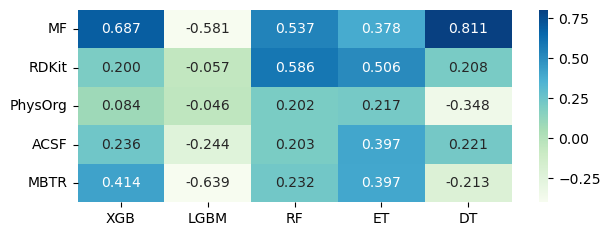

In [9]:
model_names = ['XGB', 'LGBM', 'RF', 'ET', 'DT']
res_prsr_map = np.zeros((len(c_react_desc_map),len(model_names)))
for i,desc_name in enumerate(c_react_desc_map.keys()):
    for j,model_name in enumerate(model_names):
        res_prsr_map[i,j] = res_map[(desc_name,model_name,"RDKit")][0]

plt.figure(figsize=(7,2.5))
sns.heatmap(res_prsr_map,cmap='GnBu',annot=True,fmt='.3f',xticklabels=model_names,yticklabels=c_react_desc_map.keys(),vmin=-0.4, vmax=0.8)

<Axes: >

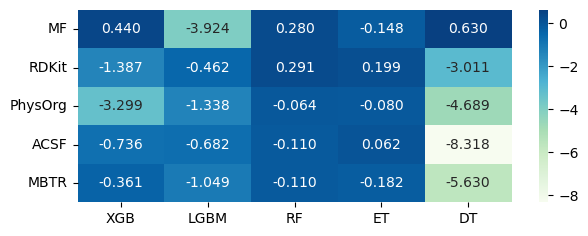

In [10]:
model_names = ['XGB', 'LGBM', 'RF', 'ET', 'DT']
res_prsr_map = np.zeros((len(c_react_desc_map),len(model_names)))
for i,desc_name in enumerate(c_react_desc_map.keys()):
    for j,model_name in enumerate(model_names):
        res_prsr_map[i,j] = res_map[(desc_name,model_name,"RDKit")][3]

plt.figure(figsize=(7,2.5))
sns.heatmap(res_prsr_map,cmap='GnBu',annot=True,fmt='.3f',xticklabels=model_names,yticklabels=c_react_desc_map.keys())

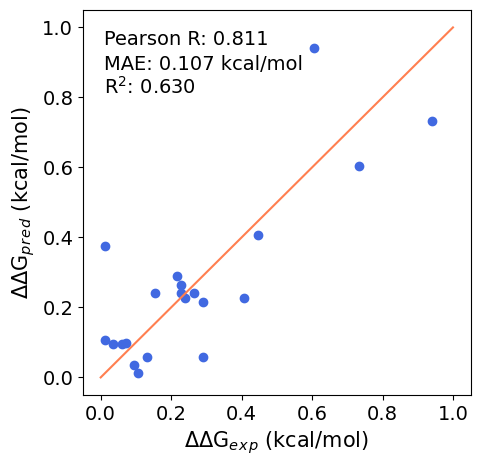

In [36]:
all_test_y,all_test_p = res_map[("MF","DT","RDKit")][1],res_map[("MF","DT","RDKit")][2]

prsr = pearsonr(all_test_y,all_test_p)[0]
mae = mean_absolute_error(all_test_y,all_test_p)
r2 = r2_score(all_test_y,all_test_p)
plt.figure(figsize=(5,5))
plt.scatter(all_test_y,all_test_p,c='royalblue')
plt.plot([0,1],[0,1],c='coral')
plt.xlabel('$\Delta$$\Delta$G$_e$$_x$$_p$ (kcal/mol)',fontsize=15)
plt.ylabel('$\Delta$$\Delta$G$_p$$_r$$_e$$_d$ (kcal/mol)',fontsize=15)
plt.text(0.01,0.95,f'Pearson R: {prsr:.3f}',fontsize=14)
plt.text(0.01,0.88,f'MAE: {mae:.3f} kcal/mol',fontsize=14)
plt.text(0.01,0.81,f'R$^2$: {r2:.3f}',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
print()